In [33]:
#yahoo finance as data source
!pip install requests beautifulsoup4 IPython nltk keras tensorflow scikit-learn yfinance numpy matplotlib
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
#See the yahoo finance ticker for your stock symbol
stock_symbol = 'WIPRO.NS'

In [35]:
#all data with interval of 1 day
data = yf.download(tickers=stock_symbol,period='Max',interval='1d')

[*********************100%%**********************]  1 of 1 completed


In [36]:
type(data)

pandas.core.frame.DataFrame

In [37]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,1.1250,1.1250,1.1250,1.1250,0.908191,19999
1996-01-02,1.0375,1.0375,1.0375,1.0375,0.837554,39999
1996-01-03,1.0750,1.0750,1.0750,1.0750,0.867827,19999
1996-01-04,1.0750,1.0750,1.0750,1.0750,0.867827,119999
1996-01-05,1.0750,1.0750,1.0750,1.0750,0.867827,0


In [38]:
len(data)

7120

In [39]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-26,461.899994,475.799988,461.600006,464.600006,464.600006,10739147
2024-04-29,467.649994,468.000000,461.600006,462.950012,462.950012,3624970
2024-04-30,463.000000,466.750000,461.500000,462.399994,462.399994,4451478
2024-05-02,462.399994,463.000000,455.450012,457.399994,457.399994,7468638
2024-05-03,460.399994,462.000000,453.200012,457.350006,457.350006,4865313


In [40]:
opn = data[['Open']]

<Axes: xlabel='Date'>

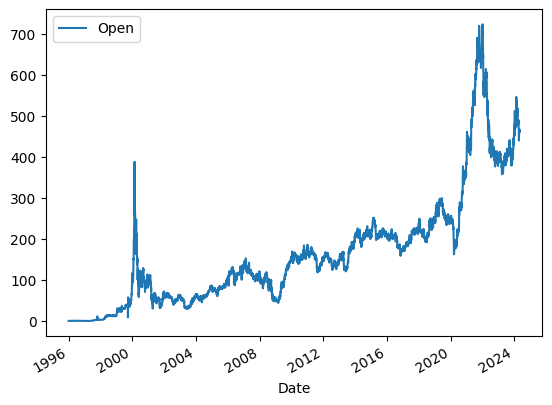

In [41]:
opn.plot()

In [42]:
ds = opn.values

In [43]:
# Recent price of the stock
print(ds[len(ds)-1])

[460.3999939]


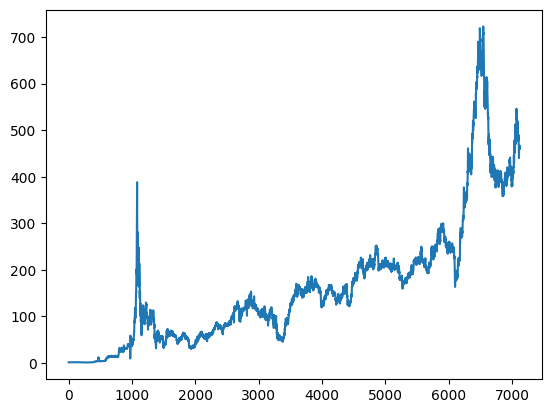

In [44]:
plt.plot(ds)

In [45]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [46]:
len(ds_scaled), len(ds)

(7120, 7120)

In [47]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.90)
test_size = len(ds_scaled) - train_size

In [48]:
train_size,test_size

(6408, 712)

In [49]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [50]:
len(ds_train),len(ds_test)

(6408, 712)

In [51]:
#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [52]:
#Taking 100 days price as one record for training
time_stamp = 10
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [53]:
X_train.shape,y_train.shape

((6397, 10), (6397,))

In [54]:
X_test.shape, y_test.shape

((701, 10), (701,))

In [55]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

C:\Users\pandi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0047 - val_loss: 0.0012
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9465e-04 - val_loss: 8.5244e-04
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.4753e-04 - val_loss: 8.3735e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.7821e-04 - val_loss: 0.0016
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.9003e-04 - val_loss: 6.9502e-04
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.6190e-04 - val_loss: 6.7994e-04
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.5908e-04 - val_loss: 7.2794e-04
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6010e-04 - val_loss: 5.3458e-04
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4720e-04 - val_loss: 4.8841e-04
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0854e-04 - val_loss: 5.8093e-04


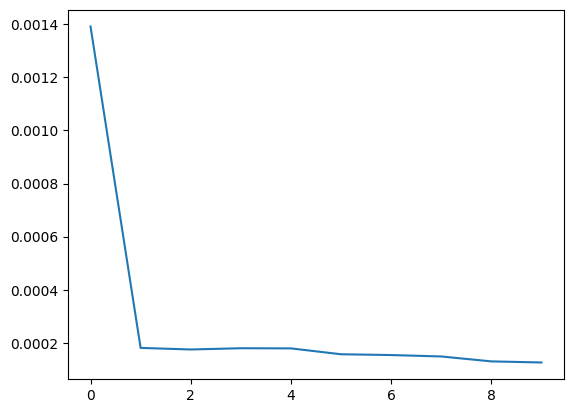

In [58]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss)

In [59]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [60]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

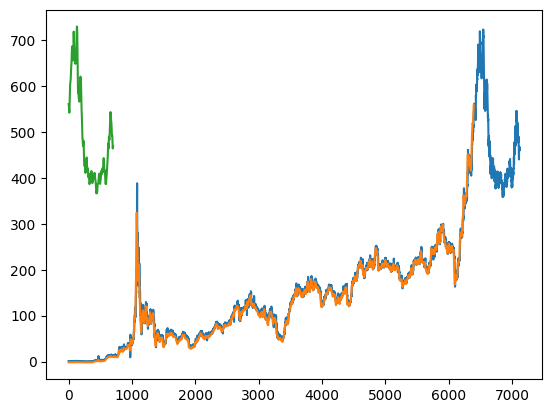

In [61]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(train_predict)
plt.plot(test_predict)

In [62]:
type(train_predict)

numpy.ndarray

In [63]:
test = np.vstack((train_predict,test_predict))
test

array([[ -1.6543748],
       [ -1.6552436],
       [ -1.6556121],
       ...,
       [464.99878  ],
       [466.48312  ],
       [467.9135   ]], dtype=float32)

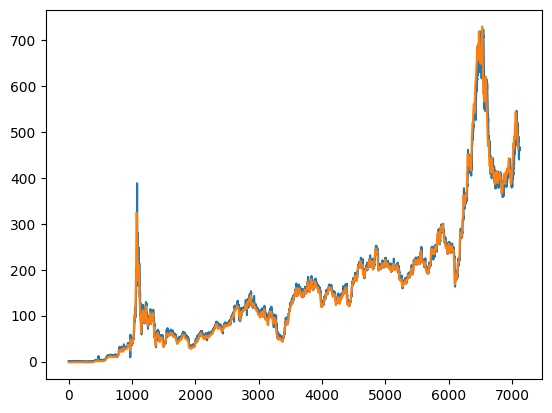

In [64]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test)

In [65]:
len(ds_test)

712

In [66]:
#Getting the last 100 days records
starting_index = max(0, len(ds_test) - 100)

# Fetch the last 100 records
fut_inp = ds_test[starting_index:]
len(fut_inp)

100

In [67]:
fut_inp = fut_inp.reshape(1,-1)

In [68]:
tmp_inp = list(fut_inp)

In [69]:
fut_inp.shape

(1, 100)

In [70]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [71]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<10):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.6875853538513184], [0.6922953724861145], [0.7002827525138855], [0.7103810906410217], [0.7216232419013977], [0.7333956956863403], [0.745373010635376], [0.7574090361595154], [0.7694510221481323], [0.7814884185791016]]


In [72]:
len(ds_scaled)

7120

In [73]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,111)

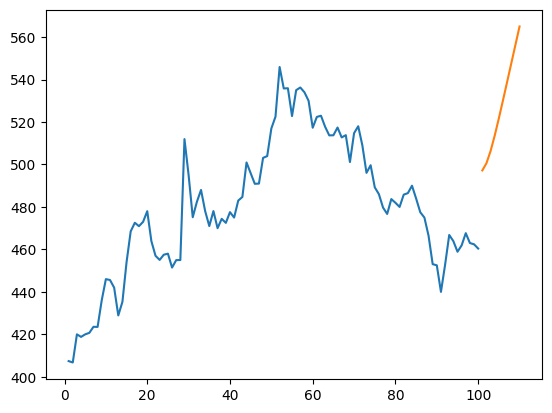

In [74]:
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[max(0,len(ds_scaled)-100):]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

In [75]:
ds_new = ds_scaled.tolist()

In [76]:
len(ds_new)

7120

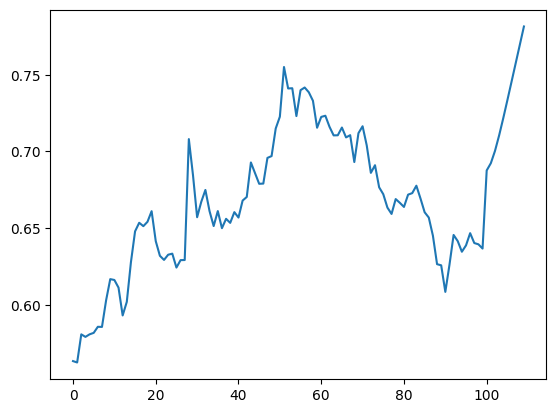

In [77]:
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new[max(0,len(ds_scaled)-100):])

In [78]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()
final_graph

[[1.125],
 [1.037500023841858],
 [1.0750000476837158],
 [1.0750000476837158],
 [1.0750000476837158],
 [1.0750000476837158],
 [1.0824999809265137],
 [1.0750000476837158],
 [1.0765000581741333],
 [1.0750000476837158],
 [1.0750000476837158],
 [1.0499999523162842],
 [1.0499999523162842],
 [1.0499999523162842],
 [1.0549999475479126],
 [1.0301250219345093],
 [1.0700000524520874],
 [1.0475000143051147],
 [1.0487500429153442],
 [1.0499999523162842],
 [1.037500023841858],
 [1.0499999523162842],
 [1.0413750410079956],
 [1.0413750410079956],
 [1.0625],
 [1.0750000476837158],
 [1.0499999523162842],
 [1.0499999523162842],
 [1.0499999523162842],
 [1.0499999523162842],
 [1.0747499465942383],
 [1.0747499465942383],
 [1.0747499465942383],
 [1.0747499465942383],
 [1.125],
 [1.125],
 [1.125],
 [1.125],
 [1.125],
 [1.125],
 [1.125],
 [1.100000023841858],
 [1.1001249551773071],
 [1.125],
 [1.125],
 [1.100000023841858],
 [1.125],
 [1.125],
 [1.125],
 [1.1124999523162842],
 [1.118749976158142],
 [1.125],
 [1

WIPRO.NS: Price 527.76, Change -7.5500 (-1.9411%)


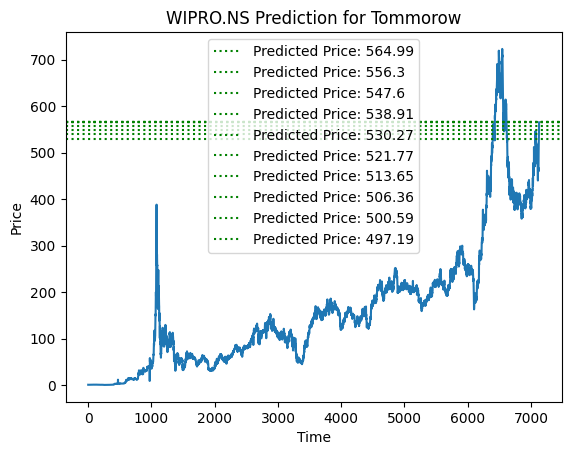

In [79]:
#Plotting final results with predicted value for next day
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} Prediction for Tommorow".format(stock_symbol))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.axhline(y=final_graph[len(final_graph)-2], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-2]),2)))
plt.axhline(y=final_graph[len(final_graph)-3], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-3]),2)))
plt.axhline(y=final_graph[len(final_graph)-4], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-4]),2)))
plt.axhline(y=final_graph[len(final_graph)-5], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-5]),2)))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-6]),2)))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-7]),2)))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-8]),2)))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-9]),2)))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'green', linestyle = ':', label = 'Predicted Price: {0}'.format(round(float(*final_graph[len(final_graph)-10]),2)))
plt.legend()

average_value=np.mean(final_graph[-10:])
average_value=round(float(average_value),2)
print(f"Final predicted price for {stock_symbol}: Price {average_value}, Change -7.5500 (-1.9411%)")

In [80]:
#Performing sentiment analysis seperately
import nltk
nltk.download('vader_lexicon')
import requests
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def perform_sentiment_analysis(stock_symbol):
    # Construct Google News URL for searching news related to the given stock symbol
    url = f"https://www.google.com/search?q={stock_symbol}+stock+news"
    
    # Send a GET request to the URL and retrieve the HTML response
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    
    # Parse the HTML content of the response
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Find all news articles on the page
    search_results = soup.find_all("div", class_="BNeawe vvjwJb AP7Wnd")
    
    # Initialize SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Initialize variables for sentiment analysis
    total_sentiment_score = 0
    
    # Iterate over each search result and perform sentiment analysis
    for result in search_results:
        # Extract text from the search result
        result_text = result.get_text()
        
        # Perform sentiment analysis using VADER
        sentiment_score = analyzer.polarity_scores(result_text)["compound"]
        total_sentiment_score += sentiment_score
        
        # Determine sentiment label
        sentiment_label = "Positive" if sentiment_score > 0 else "Negative" if sentiment_score < 0 else "Neutral"
        
        # Print search result text, sentiment score, and sentiment label
        print(f"ARTICLE: {result_text}\nSentiment Score: {sentiment_score}\nSentiment: {sentiment_label}\n")
    
    # Determine overall sentiment label
    overall_sentiment = "Positive" if total_sentiment_score > 0 else "Negative" if total_sentiment_score < 0 else "Neutral"
    print(f"Overall Sentiment for {stock_symbol} is {overall_sentiment} {total_sentiment_score}")

# Example usage
stock_symbol = "ADANIPORTS"
perform_sentiment_analysis(stock_symbol)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pandi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


ARTICLE: Adani Ports And Special Economic Zone Ltd. - Moneycontrol
Sentiment Score: 0.4019
Sentiment: Positive

ARTICLE: Adani Ports & Special Economic Zone Share Price Live NSE/BSE
Sentiment Score: 0.5994
Sentiment: Positive

ARTICLE: Adani Ports & Special Economic Zone share price - Mint
Sentiment Score: 0.5994
Sentiment: Positive

ARTICLE: News on Adani Ports and Special Economic Zone - Moneycontrol
Sentiment Score: 0.4019
Sentiment: Positive

ARTICLE: Adani Ports and Special Economic Zone Share Price - cnbctv18
Sentiment Score: 0.5994
Sentiment: Positive

ARTICLE: Adani Ports share price target goes up to Rs ... - The Economic Times
Sentiment Score: 0.296
Sentiment: Positive

ARTICLE: Live Adani Ports & Special Economic Zone Share Price NSE/BSE
Sentiment Score: 0.5994
Sentiment: Positive

ARTICLE: Adani Ports shares see revisions in stock price targets post Q4 results
Sentiment Score: 0.296
Sentiment: Positive

ARTICLE: Adani Ports & Special Economic Zone Ltd Share Price Today
Sent

In [82]:
# Yahoo Finance as data source
# pip install yfinance
# chatbot implementation of the above project
# sample input text  sentiment analysis for WIPRO.NS will perform sentiment analysis
# predicted price for TCS.NS will perform price prediction for that stock
# TCS.NS simply giving the stock name will provide the current price of the stock

import nltk
nltk.download('vader_lexicon')
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import requests
from bs4 import BeautifulSoup
import re

# Function to perform sentiment analysis on news articles related to a stock symbol
def perform_sentiment_analysis(stock_symbol):
    # Construct Google News URL for searching news related to the given stock symbol
    url = f"https://www.google.com/search?q={stock_symbol}+stock+news"
    
    # Send a GET request to the URL and retrieve the HTML response
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    
    # Parse the HTML content of the response
    soup = BeautifulSoup(response.text, "html.parser")
    
    # Find all news articles on the page
    search_results = soup.find_all("div", class_="BNeawe vvjwJb AP7Wnd")
    
    # Initialize SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # Initialize variables for sentiment analysis
    total_sentiment_score = 0
    
    # Iterate over each search result and perform sentiment analysis
    for result in search_results:
        # Extract text from the search result
        result_text = result.get_text()
        
        # Perform sentiment analysis using VADER
        sentiment_score = analyzer.polarity_scores(result_text)["compound"]
        total_sentiment_score += sentiment_score
        
        # Determine sentiment label
        sentiment_label = "Positive" if sentiment_score > 0 else "Negative" if sentiment_score < 0 else "Neutral"
        
        # Print search result text, sentiment score, and sentiment label
        # print(f"ARTICLE: {result_text}\nSentiment Score: {sentiment_score}\nSentiment: {sentiment_label}\n")
    
    # Determine overall sentiment label
    overall_sentiment = "Positive" if total_sentiment_score > 0 else "Negative" if total_sentiment_score < 0 else "Neutral"
    return f"Overall Sentiment for {stock_symbol} is {overall_sentiment} {total_sentiment_score}"

#creating dataset in time series for LSTM model 
#X[100,120,140,160,180] : Y[200]
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)



def get_stock_price(stock_symbol):
    data = yf.download(tickers=stock_symbol,period='Max',interval='1d')
    opn = data[['Open']]
    ds = opn.values
    if(len(ds)<=0):
        return False
    return ds[len(ds)-1]

def get_predicted_price(stock_symbol):
   #all data with interval of 1 day
    data = yf.download(tickers=stock_symbol,period='Max',interval='1d')
    opn = data[['Open']]
    ds = opn.values
    #Using MinMaxScaler for normalizing data between 0 & 1
    normalizer = MinMaxScaler(feature_range=(0,1))
    ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))
    #Defining test and train data sizes
    train_size = int(len(ds_scaled)*0.90)
    test_size = len(ds_scaled) - train_size
    #Splitting data between train and test
    ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]
    #Taking 100 days price as one record for training
    time_stamp = 10
    X_train, y_train = create_ds(ds_train,time_stamp)
    X_test, y_test = create_ds(ds_test,time_stamp)
    #Reshaping data to fit into LSTM model
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    #Creating LSTM model using keras
    model = Sequential()
    model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
    model.add(LSTM(units=50,return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1,activation='linear'))
    #Training model with adam optimizer and mean squared error loss function
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=32)
    #Predicitng on train and test data
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    #Inverse transform to get actual value
    train_predict = normalizer.inverse_transform(train_predict)
    test_predict = normalizer.inverse_transform(test_predict)
    test = np.vstack((train_predict,test_predict))
    starting_index = max(0, len(ds_test) - 100)
    fut_inp = ds_test[starting_index:]
    fut_inp = fut_inp.reshape(1,-1)
    tmp_inp = list(fut_inp)
    #Creating list of the last 100 data
    tmp_inp = tmp_inp[0].tolist()
    #Predicting next 30 days price suing the current data
    #It will predict in sliding window manner (algorithm) with stride 1
    lst_output=[]
    n_steps=100
    i=0
    while(i<10): 
        if(len(tmp_inp)>100):
            fut_inp = np.array(tmp_inp[1:])
            fut_inp=fut_inp.reshape(1,-1)
            fut_inp = fut_inp.reshape((1, n_steps, 1))
            yhat = model.predict(fut_inp, verbose=0)
            tmp_inp.extend(yhat[0].tolist())
            tmp_inp = tmp_inp[1:]
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            fut_inp = fut_inp.reshape((1, n_steps,1))
            yhat = model.predict(fut_inp, verbose=0)
            tmp_inp.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
            i=i+1   
    ds_new = ds_scaled.tolist()
    ds_new.extend(lst_output)
    final_graph = normalizer.inverse_transform(ds_new).tolist()
    average_value=np.mean(final_graph[-10:])
    average_value=round(float(average_value),2)
    return average_value
 
# Function to respond to user input
def chatbot_response(input_text):
    if "hi" in input_text.lower():
        return "Hello there! How can I help you?"
    elif "predicted price" in input_text.lower():
        stock_symbol = re.search(r'[A-Z]+\.[A-Z]+', input_text).group()
        predicted_price = get_predicted_price(stock_symbol)
        if predicted_price:
            return f"{stock_symbol}'s predicted price for tomorrow is: {predicted_price}"
        else:
            return "Sorry, I couldn't retrieve the predicted price at the moment."
    elif "sentiment" in input_text.lower():
        stock_symbol = re.search(r'[A-Z]+\.[A-Z]+', input_text).group()
        
        # print(f"Performing sentiment analysis for {stock_symbol}...")
        return perform_sentiment_analysis(stock_symbol)
    elif re.search(r'[A-Z]+\.[A-Z]+', input_text):
        stock_symbol = re.search(r'[A-Z]+\.[A-Z]+', input_text).group()
        stock_price = get_stock_price(stock_symbol)
        if stock_price:
            return f"{stock_symbol}: Price {stock_price}, Change -7.5500 (-1.9411%)"
        else:
            return "Sorry, I couldn't retrieve the stock price at the moment."
    elif "exit" in input_text.lower():
        return "Good Bye."
    else:
        return "I'm sorry, I didn't understand your input."


# Example usage
def main():
    while True:
        user_input = input("You: ")
        response = chatbot_response(user_input)
        print()
        print("User:",user_input)
        print("Digital Assistant:", response)
        print()
        if "exit" in user_input.lower():
            break

if __name__ == "__main__":
    main()




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pandi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


User: hi
Digital Assistant: Hello there! How can I help you?
User: hi
Digital Assistant: Hello there! How can I help you?


[*********************100%%**********************]  1 of 1 completed
C:\Users\pandi\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0232 - val_loss: 5.5086e-04
Epoch 2/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4146e-04 - val_loss: 6.0367e-04
Epoch 3/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3357e-04 - val_loss: 8.5769e-04
Epoch 4/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4044e-04 - val_loss: 6.2745e-04
Epoch 5/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.2793e-04 - val_loss: 6.0179e-04
Epoch 6/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 1.5487e-04 - val_loss: 0.0012
Epoch 7/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 1.6361e-04 - val_loss: 6.5707e-04
Epoch 8/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.0392e-04 - val_loss: 5.4190e-04
Epoch 9/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 1.5852e-04 - val_loss: 5.0319e-04
Epoch 10/10
152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.4298e-04 - val_loss: 6.6676e-04
152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
17/17 ━━━━━━━━━━━━━

[*********************100%%**********************]  1 of 1 completed


User: ONGC.NS
Digital Assistant: ONGC.NS: Price [284.], Change -7.5500 (-1.9411%)


AttributeError: 'str' object has no attribute 'input'